# Load Dataset

In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import transformers
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def convert_to_time(hmm):
    # Ensure elements are scalar ints (handles numpy objects)
    hmm = [int(x.item() if isinstance(x, np.ndarray) and x.size == 1 else int(x)) for x in hmm]
    year, month, day, hour, minute, second = hmm
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_list = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}

        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0]
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l

        # Extract possible array values safely
        type_val = col[i][0][0]
        temp_val = col[i][1][0]
        time_val = col[i][2][0]  # 6-element array (year..sec)

        # Convert type and temp safely
        if isinstance(type_val, np.ndarray) and type_val.size == 1:
            type_val = type_val.item()
        if isinstance(temp_val, np.ndarray) and temp_val.size == 1:
            temp_val = temp_val.item()

        d1['type'] = str(type_val)
        d1['temp'] = int(temp_val)
        d1['time'] = str(convert_to_time(time_val))
        d1['data'] = d2

        data_list.append(d1)

    return data_list

# get input features (all columns except capacity)
def getBatteryInputs(Battery, feature_list=None, include_temp=True):
    """
    Returns inputs for all discharge cycles and the feature names.
    Automatically removes features that are constant across all batteries.
    """
    inputs = []

    # Determine initial feature list from first discharge cycle
    if feature_list is None:
        for Bat in Battery:
            if Bat['type'] == 'discharge':
                feature_list = list(Bat['data'].keys())
                if 'Capacity' in feature_list:
                    feature_list.remove('Capacity')
                break

    # Include temp if requested
    if include_temp:
        feature_list.append('temp')

    # Build a 2D array: rows = cycles across all batteries, cols = features
    all_data = []
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            row = []
            for f in feature_list:
                if f == 'temp':
                    row.append(Bat['temp'])
                else:
                    row.append(Bat['data'].get(f, [0])[0])
            all_data.append(row)
    all_data = np.array(all_data, dtype=np.float32)  # shape: (num_cycles_total, num_features)

    # Remove features that are constant (same value in all rows)
    is_constant = np.all(all_data == all_data[0, :], axis=0)
    cleaned_data = all_data[:, ~is_constant]
    cleaned_feature_list = [f for f, keep in zip(feature_list, ~is_constant) if keep]

    return cleaned_data, cleaned_feature_list

# get capacity data
def getBatteryCapacity(Battery):
    """
    Returns 1D array of capacity for all discharge cycles.
    """
    capacities = []
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacities.append(Bat['data']['Capacity'][0])
    return np.array(capacities, dtype=np.float32)

In [3]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'dataset/'

Battery_dict = {}
for name in Battery_list:
    print(f'Loading {name}')
    path = dir_path + name + '.mat'
    data = loadMat(path)

    X, feature_list = getBatteryInputs(data)      # inputs for discharge cycles
    y = getBatteryCapacity(data)    # capacity as target

    Battery_dict[name] = (X, y)

Loading B0005
Loading B0006
Loading B0007
Loading B0018


In [4]:
window_size = 15  # sliding window

X_all_windows = []
y_all_windows = []
battery_ids = []

y_scalers = {}  # per-battery scaler
x_scalers = {}  # per-battery scaler

for b_idx, (name, (X, y)) in enumerate(Battery_dict.items()):
    # Feature derivatives
    X_diff = np.diff(X, axis=0, prepend=X[0:1,:])
    cycle_idx = np.arange(len(X)).reshape(-1,1)/len(X)
    y_prev = np.roll(y,1).reshape(-1,1); y_prev[0]=y[0]
    cum_discharge = np.cumsum(X[:,1]).reshape(-1,1)
    temp_diff = np.diff(X[:,2], prepend=X[0,2:3]).reshape(-1,1)
    
    X_combined = np.hstack([X, X_diff, cycle_idx, y_prev, cum_discharge, temp_diff])
    
    # Battery ID as feature (one-hot or integer, here integer)
    battery_feat = np.full((len(X_combined),1), b_idx)
    X_combined = np.hstack([X_combined, battery_feat])
    
    # Battery-specific scaling
    x_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X_combined)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
    
    x_scalers[name] = x_scaler
    y_scalers[name] = y_scaler
    
    # Sliding window
    for i in range(len(X_scaled)-window_size):
        X_all_windows.append(X_scaled[i:i+window_size])
        y_all_windows.append(y_scaled[i+window_size,0])
        battery_ids.append(b_idx)

X_all_windows = np.array(X_all_windows)
y_all_windows = np.array(y_all_windows)

In [6]:
split_idx = int(0.6*len(X_all_windows))
X_train, X_test = X_all_windows[:split_idx], X_all_windows[split_idx:]
y_train, y_test = y_all_windows[:split_idx], y_all_windows[split_idx:]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# Deep Learning Model

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:,:x.size(1), :]

In [17]:
class BatteryTransformerWeighted(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2,
                 dim_feedforward=128, dropout=0.1, last_frac=0.3, last_weight=3.0):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(d_model, 1)

        self.last_frac = last_frac     # Fraction of sequence to emphasize
        self.last_weight = last_weight # Weight factor for last part of sequence

    def forward(self, x):
        """
        x: [batch, seq_len, num_features]
        """
        seq_len = x.size(1)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.encoder(x)  # [batch, seq_len, d_model]

        # Create weights for weighted mean pooling
        weights = torch.ones(seq_len, device=x.device)
        last_start = int(seq_len * (1 - self.last_frac))
        weights[last_start:] = self.last_weight
        weights = weights / weights.sum()  # normalize

        # Weighted sum over sequence
        x = (x * weights.unsqueeze(1)).sum(dim=1)

        x = self.dropout(x)
        out = self.regressor(x).squeeze(-1)  # [batch]
        return out

model = BatteryTransformerWeighted(num_features=X_train_t.shape[-1],
                           d_model=128, nhead=4, num_layers=2,
                           dim_feedforward=256, dropout = 0.1).to(device)

In [18]:
# optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.HuberLoss()

epochs = 500
patience = 50
best_loss = float('inf')
trigger_times = 0
best_state = None

for epoch in range(epochs):
    # -------------------------------
    # Training
    # -------------------------------
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    # -------------------------------
    # Validation
    # -------------------------------
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_t)
        test_loss = criterion(y_test_pred, y_test_t).item()

    # -------------------------------
    # Check for improvement
    # -------------------------------
    if test_loss < best_loss - 1e-6:  # tiny margin to avoid floating noise
        best_loss = test_loss
        best_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1

    if (epoch + 1) % 25 == 0 or trigger_times == patience:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.6f} | Test Loss: {test_loss:.6f}")

    # -------------------------------
    # Early stopping condition
    # -------------------------------
    if trigger_times >= patience:
        print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
        break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"✅ Restored best model with test loss: {best_loss:.6f}")

Epoch 25/500 | Train Loss: 0.031854 | Test Loss: 0.037322
Epoch 50/500 | Train Loss: 0.007152 | Test Loss: 0.004622
Epoch 75/500 | Train Loss: 0.006505 | Test Loss: 0.003148
Epoch 100/500 | Train Loss: 0.004699 | Test Loss: 0.002298
Epoch 125/500 | Train Loss: 0.003457 | Test Loss: 0.002060
Epoch 150/500 | Train Loss: 0.003029 | Test Loss: 0.002345
Epoch 175/500 | Train Loss: 0.002262 | Test Loss: 0.001699
Epoch 200/500 | Train Loss: 0.002101 | Test Loss: 0.001757
Epoch 225/500 | Train Loss: 0.001487 | Test Loss: 0.001684
Epoch 250/500 | Train Loss: 0.001499 | Test Loss: 0.001631
Epoch 275/500 | Train Loss: 0.001256 | Test Loss: 0.001582
Epoch 300/500 | Train Loss: 0.001193 | Test Loss: 0.001707
Epoch 325/500 | Train Loss: 0.001162 | Test Loss: 0.001522
Epoch 350/500 | Train Loss: 0.001204 | Test Loss: 0.002068
Epoch 375/500 | Train Loss: 0.001202 | Test Loss: 0.001577
Epoch 400/500 | Train Loss: 0.000984 | Test Loss: 0.001893
Epoch 425/500 | Train Loss: 0.000844 | Test Loss: 0.001507


Battery B0005 RMSE: 0.0176 Ah


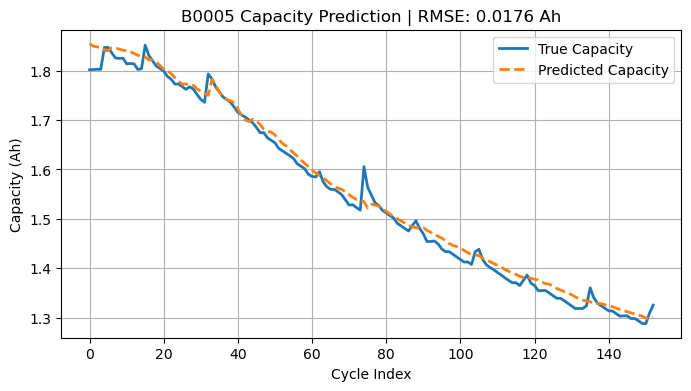

Battery B0006 RMSE: 0.0323 Ah


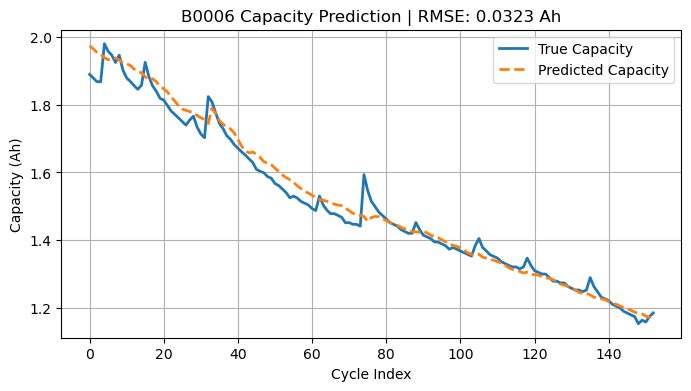

Battery B0007 RMSE: 0.0163 Ah


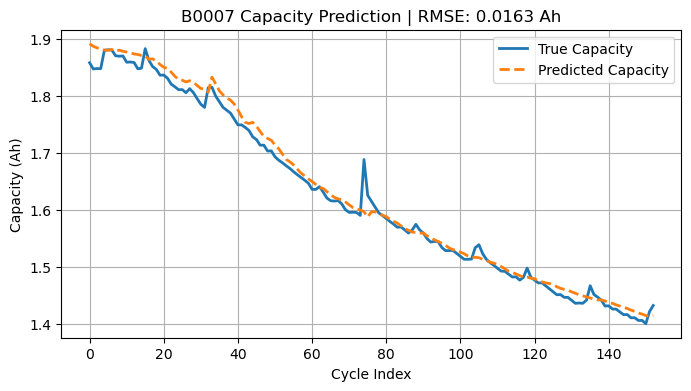

Battery B0018 RMSE: 0.0381 Ah


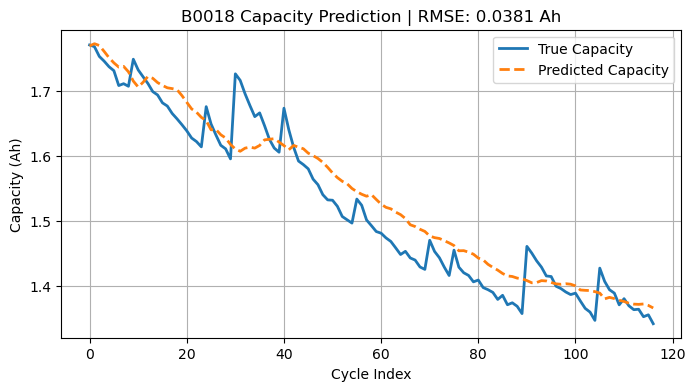

In [19]:
model.eval()
for b_idx, (name, (X, y)) in enumerate(Battery_dict.items()):
    # -----------------------------
    # Feature engineering
    # -----------------------------
    X_diff = np.diff(X, axis=0, prepend=X[0:1,:])
    cycle_idx = np.arange(len(X)).reshape(-1,1)/len(X)
    y_prev = np.roll(y,1).reshape(-1,1); y_prev[0]=y[0]
    cum_discharge = np.cumsum(X[:,1]).reshape(-1,1)
    temp_diff = np.diff(X[:,2], prepend=X[0,2:3]).reshape(-1,1)
    
    # Combine all features
    battery_feat = np.full((len(X),1), b_idx)
    X_combined = np.hstack([X, X_diff, cycle_idx, y_prev, cum_discharge, temp_diff, battery_feat])
    
    # Scale features
    X_scaled = x_scalers[name].transform(X_combined)
    
    # -----------------------------
    # Sliding window prediction
    # -----------------------------
    preds_scaled = []
    for i in range(len(X_scaled)-window_size):
        x_win = torch.tensor(X_scaled[i:i+window_size], dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            p = model(x_win).cpu().numpy()
        preds_scaled.append(p)
    
    preds_scaled = np.array(preds_scaled).ravel()
    y_true = y[window_size:]
    preds = y_scalers[name].inverse_transform(preds_scaled.reshape(-1,1)).ravel()
    
    # -----------------------------
    # Compute RMSE
    # -----------------------------
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    print(f"Battery {name} RMSE: {rmse:.4f} Ah")
    
    # -----------------------------
    # Plot true vs predicted
    # -----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(y_true, label='True Capacity', linewidth=2)
    plt.plot(preds, '--', label='Predicted Capacity', linewidth=2)
    plt.title(f'{name} Capacity Prediction | RMSE: {rmse:.4f} Ah')
    plt.xlabel('Cycle Index')
    plt.ylabel('Capacity (Ah)')
    plt.legend()
    plt.grid(True)
    plt.show()